In [1]:
import os, re, json
import numpy as np

# plotting styles
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

mpl.rcParams['figure.dpi'] = 150

# change to the root folder
base_dir = "/Users/jibanmac/Documents/GitHub/gpy_dla_detection/"
os.chdir(base_dir)

try:
    assert "null_gp.py" in os.listdir("gpy_dla_detection")
except Exception as e:
    print(e)
    print(
        "[Warning] Change the directory of base_dir to the path of your gpy_dla_detection repository."
    )

In [2]:
# The test selection file includes a list of 100 quasar spectra and their redshifts
from tests import test_selection

# The module to read spectrum, which also helps us to download the file (for SDSS DR12 spectrum)
from gpy_dla_detection.read_spec import read_spec, retrieve_raw_spec

In [3]:
with open(
    "data/dla_catalogs/dr12q_gp/predictions_multi_DLAs_lyseries_a03.json", "r"
) as f:
    dr12q_catalog = json.load(f)

In [4]:
def download_and_read(
    plate: int,
    mjd: int,
    fiber_id: int,
):
    filename = "spec-{:d}-{:d}-{:04d}.fits".format(plate, mjd, fiber_id)

    # If we haven't downloaded the file, this cell will help you download the file from SDSS database
    if not os.path.exists(filename):
        # This line gets the plate, mjd, and fiber_id from the given filename
        # Note: re is the regex.
        plate, mjd, fiber_id = re.findall(
            r"spec-([0-9]+)-([0-9]+)-([0-9]+).fits",
            filename,
        )[0]
        # Download the file using the given plate, mjd, and fiber_id
        retrieve_raw_spec(int(plate), int(mjd), int(fiber_id))

    # make sure the file exists
    assert os.path.exists(filename) == True

    # Read the raw spectrum: This line reads the spectrum file into four numpy arrays
    wavelengths, flux, noise_variance, pixel_mask = read_spec(filename)
    # simulated data
    # you have : wavelengths (velocities), flux
    # noise_variance : you need to inject your own noise
    # pixel_mask : you don't have. pixel_mask is the invalid pixel in spectrum
    return wavelengths, flux, noise_variance, pixel_mask

In [5]:
real_index = np.where(
    [
        (spec["p_dla"] > 0.9 and spec["snr"] > 8 and spec["z_qso"] > 3)
        for spec in dr12q_catalog
    ]
)[0]
real_index

array([    51,     76,    101, ..., 158780, 158811, 158824])

In [6]:
ith = 0

spec_dict = dr12q_catalog[real_index[ith]]

# extract info
plate = spec_dict["plate"]
mjd = spec_dict["mjd"]
fiber_id = spec_dict["fiber_id"]

z_qso = spec_dict["z_qso"]

# dla detection
dlas_dict = spec_dict["dlas"]
num_dlas = len(dlas_dict)
z_dlas = []
log_nhis = []
for j in range(num_dlas):
    z_dlas.append(dlas_dict[j]["z_dla"])
    log_nhis.append(dlas_dict[j]["log_nhi"])

spec_dict

{'p_dla': 0.9999999999999999,
 'p_no_dla': 2.024344498834639e-32,
 'max_model_posterior': 0.9988940794493255,
 'num_dlas': 2,
 'min_z_dla': 2.030863372651819,
 'max_z_dla': 3.0179441471631363,
 'snr': 26.150687052443182,
 'ra': 0.06321446111104478,
 'dec': 0.8092482880234474,
 'plate': 4216,
 'mjd': 55477,
 'fiber_id': 718,
 'thing_id': 113606237,
 'z_qso': 3.027761220932007,
 'dlas': [{'log_nhi': 20.755368819510455, 'z_dla': 2.1359937407867218},
  {'log_nhi': 20.72436622286896, 'z_dla': 2.5236808003558338}]}

(-1.0, 5.0)

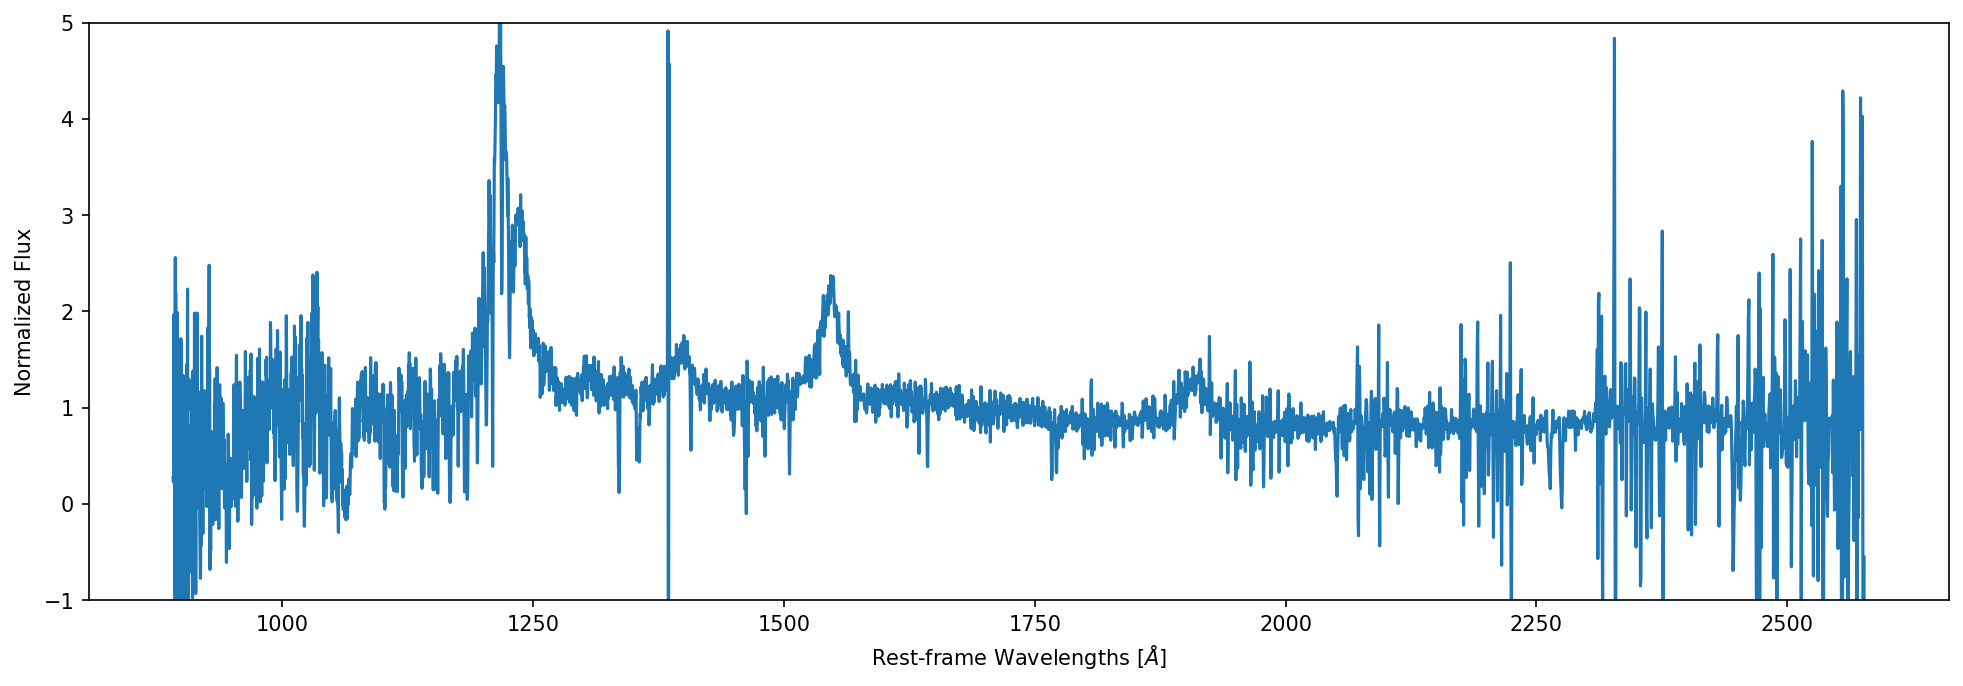

In [7]:
wavelengths, flux, noise_variance, pixel_mask = download_and_read(plate, mjd, fiber_id)

rest_wavelengths = wavelengths / (1 + z_qso)

plt.figure(figsize=(16, 5))
# I did a normalization in this step to make the plot esier to see
plt.plot(rest_wavelengths, flux / np.mean(flux))
plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Normalized Flux")
plt.ylim(-1, 5)

## Create the Bayesian model


In [8]:
from gpy_dla_detection.set_parameters import Parameters

# Note: these parameters are used during training. Change these parameters here won't change your
# trained GP model unless you re-train your GP model.
param = Parameters(
    loading_min_lambda=800,  # range of rest wavelengths to load  Å
    loading_max_lambda=1550,
    # normalization parameters
    normalization_min_lambda=1425,  # range of rest wavelengths to use   Å
    normalization_max_lambda=1475,  #   for flux normalization
    # null model parameters
    min_lambda=850.75,  # range of rest wavelengths to       Å
    max_lambda=1420.75,  #   model
    dlambda=0.25,  # separation of wavelength grid      Å
    k=20,  # rank of non-diagonal contribution
    max_noise_variance=3**2,  # maximum pixel noise allowed during model training
)

# BOSS DR12 effective optical depth
param.tau_0_mu = 0.00554  # meanflux suppression for τ₀
param.tau_0_sigma = 0.00064  # meanflux suppression for τ₀
param.beta_mu = 3.182  # meanflux suppression for β
param.beta_sigma = 0.074  # meanflux suppression for β

param

{'loading_min_lambda': 800, 'loading_max_lambda': 1550, 'z_qso_cut': 2.15, 'min_num_pixels': 200, 'normalization_min_lambda': 1425, 'normalization_max_lambda': 1475, 'min_lambda': 850.75, 'max_lambda': 1420.75, 'dlambda': 0.25, 'k': 20, 'max_noise_variance': 9, 'initial_c_0': 0.1, 'initial_tau_0': 0.0023, 'initial_beta': 3.65, 'minFunc_options': {'MaxIter': 2000, 'MaxFunEvals': 4000}, 'num_dla_samples': 10000, 'alpha': 0.97, 'uniform_min_log_nhi': 20.0, 'uniform_max_log_nhi': 23.0, 'fit_min_log_nhi': 20.0, 'fit_max_log_nhi': 22.0, 'prior_z_qso_increase': 0.10006922855944561, 'width': 3, 'pixel_spacing': 0.0001, 'num_lines': 3, 'max_z_cut': 0.010006922855944561, 'min_z_cut': 0.010006922855944561, 'num_forest_lines': 31, 'tau_0_mu': 0.00554, 'tau_0_sigma': 0.00064, 'beta_mu': 3.182, 'beta_sigma': 0.074}

In [9]:
from gpy_dla_detection.model_priors import PriorCatalog

# Note: you need to follow the README to download these files!
prior = PriorCatalog(
    param,
    "data/dr12q/processed/catalog.mat",
    "data/dla_catalogs/dr9q_concordance/processed/los_catalog",
    "data/dla_catalogs/dr9q_concordance/processed/dla_catalog",
)
prior

In [10]:
from gpy_dla_detection.null_gp import NullGP
from gpy_dla_detection.dla_gp import DLAGP

# Use h5py to read the learned GP model
import h5py


# Null model GP : a GP model without any DLA intervening.
# Note that it's model without DLAs, so the noise term might still include some
# LLS or subDLAs
class NullGPDR12(NullGP):
    """
    Load learned model from SDSS DR12 data without DLAs

    params: globla parameters used to train the model and some parameters define to priors of the model.
    prior: the prior catalog based on SDSS DR9 Lya catalog (We haven't switch to DR12 DLA catalog, we could
        use Ho-Bird-Garnett 2020 catalog). You can change the definition of self.log_prior
        to overwrite the prior from prior catalog.
    learned_file: the input .MAT file for the learned GP model.
    prev_tau_0: tau_0 to change the meanflux of the GP mean function. The effective meanflux model is
        tau = tau_0 * exp( -(1 + z)^beta ). Details see gpy_dla_detection/effective_optical_depth.py
    prev_beta: beta to change the meanflux of thte GP mean function.
    """

    def __init__(
        self,
        params: Parameters,
        prior: PriorCatalog,
        learned_file: str = "learned_qso_model_lyseries_variance_kim_dr9q_minus_concordance.mat",
        prev_tau_0: float = 0.0023,
        prev_beta: float = 3.65,
    ):
        with h5py.File(learned_file, "r") as learned:
            rest_wavelengths = learned["rest_wavelengths"][:, 0]
            mu = learned["mu"][:, 0]
            M = learned["M"][()].T
            log_omega = learned["log_omega"][:, 0]
            log_c_0 = learned["log_c_0"][0, 0]
            log_tau_0 = learned["log_tau_0"][0, 0]
            log_beta = learned["log_beta"][0, 0]

        super().__init__(
            params,
            prior,
            rest_wavelengths,
            mu,
            M,
            log_omega,
            log_c_0,
            log_tau_0,
            log_beta,
            prev_tau_0=prev_tau_0,
            prev_beta=prev_beta,
        )


# get the instance of GP null model
gp = NullGPDR12(
    params=param,
    prior=prior,
    # you should put your downloaded file in this directory
    learned_file="data/dr12q/processed/learned_qso_model_lyseries_variance_wmu_boss_dr16q_minus_dr12q_gp_851-1421.mat",
    # SDSS/BOSS DR12 meanflux effective optical depth for Lyman alpha forest
    prev_tau_0=0.00554,  # suppression: tau
    prev_beta=3.182,  # suppression: beta
)

# Make the GP model interpolated onto the observed quasar spectum
gp.set_data(rest_wavelengths, flux, noise_variance, pixel_mask, z_qso, build_model=True)

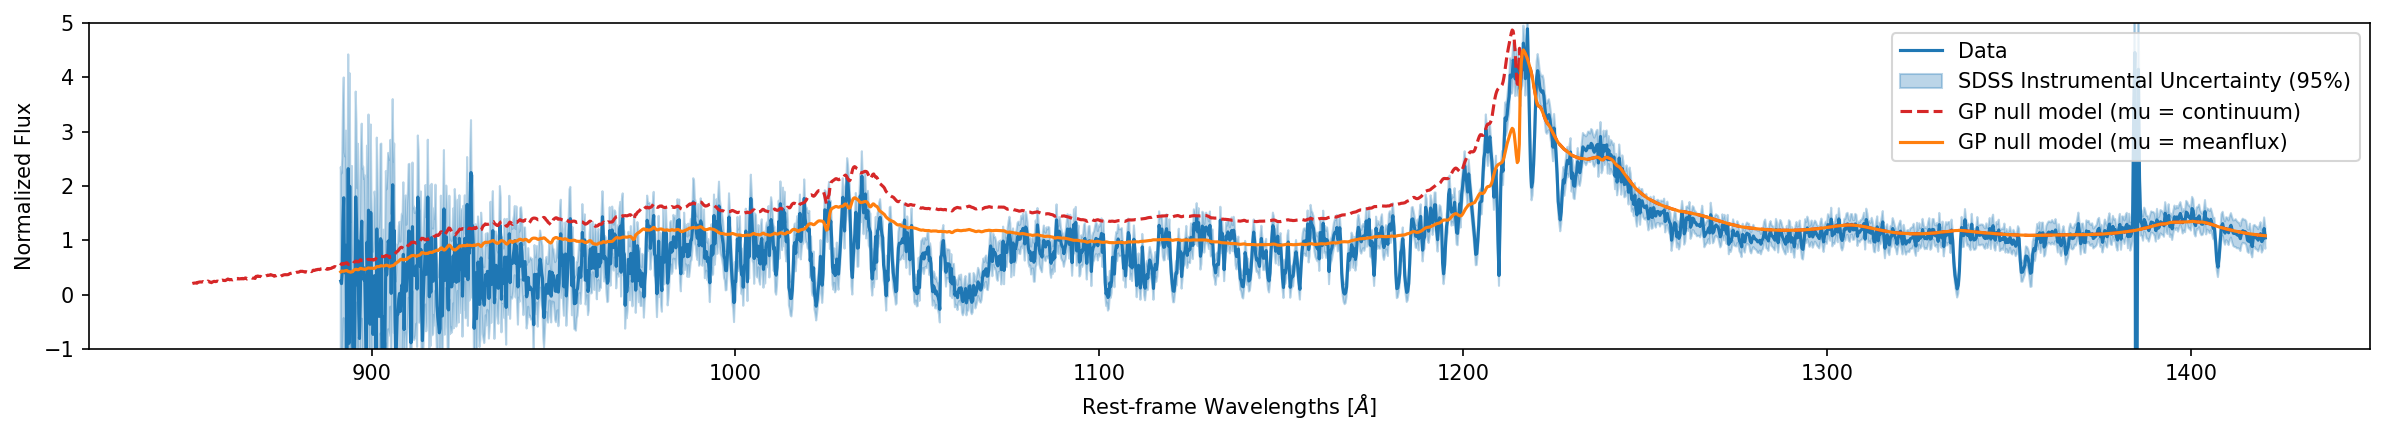

In [11]:
plt.figure(figsize=(16, 3))

# Mean function
plt.plot(
    gp.X,  # quasar spectrum's rest-frame wavelengths
    gp.Y,  # quasar spectrum's flux
    label="Data",
)
plt.fill_between(
    gp.X,
    gp.Y - 2 * np.sqrt(gp.v),
    gp.Y + 2 * np.sqrt(gp.v),
    label="SDSS Instrumental Uncertainty (95%)",
    color="C0",
    alpha=0.3,
)
plt.plot(
    gp.rest_wavelengths,
    gp.mu,
    label="GP null model (mu = continuum)",
    color="C3",
    ls="--",
)
plt.plot(
    gp.X, gp.this_mu, label="GP null model (mu = meanflux)"  # GP model's mean function
)
plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Normalized Flux")
plt.legend(loc="upper right")
plt.ylim(-1, 5)
plt.tight_layout()
plt.savefig("poster-plot.png", format="png", dpi=300, transparent=True)

In [12]:
sample = np.random.multivariate_normal(gp.mu, gp.K, size=1000)

In [13]:
def make_gp_sample_plot(i):
    fig, ax = plt.subplots(1, 1, figsize=(16, 3))
    ax.plot(gp.rest_wavelengths, gp.mu)
    ax.plot(gp.rest_wavelengths, sample[i, :], color="C1", alpha=0.9)
    ax.fill_between(gp.rest_wavelengths, sample[i, :], gp.mu, color="C1", alpha=0.1)

    ax.set_ylim(-1, 6)
    ax.set(yticklabels=[])

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    ax.set_xlabel("Rest-frame Wavelengths [$\AA$]", fontdict={"fontsize": 16})

    fig.tight_layout()

    return fig

In [24]:
sort_index = np.argsort(sample.mean(axis=1))[::-1]

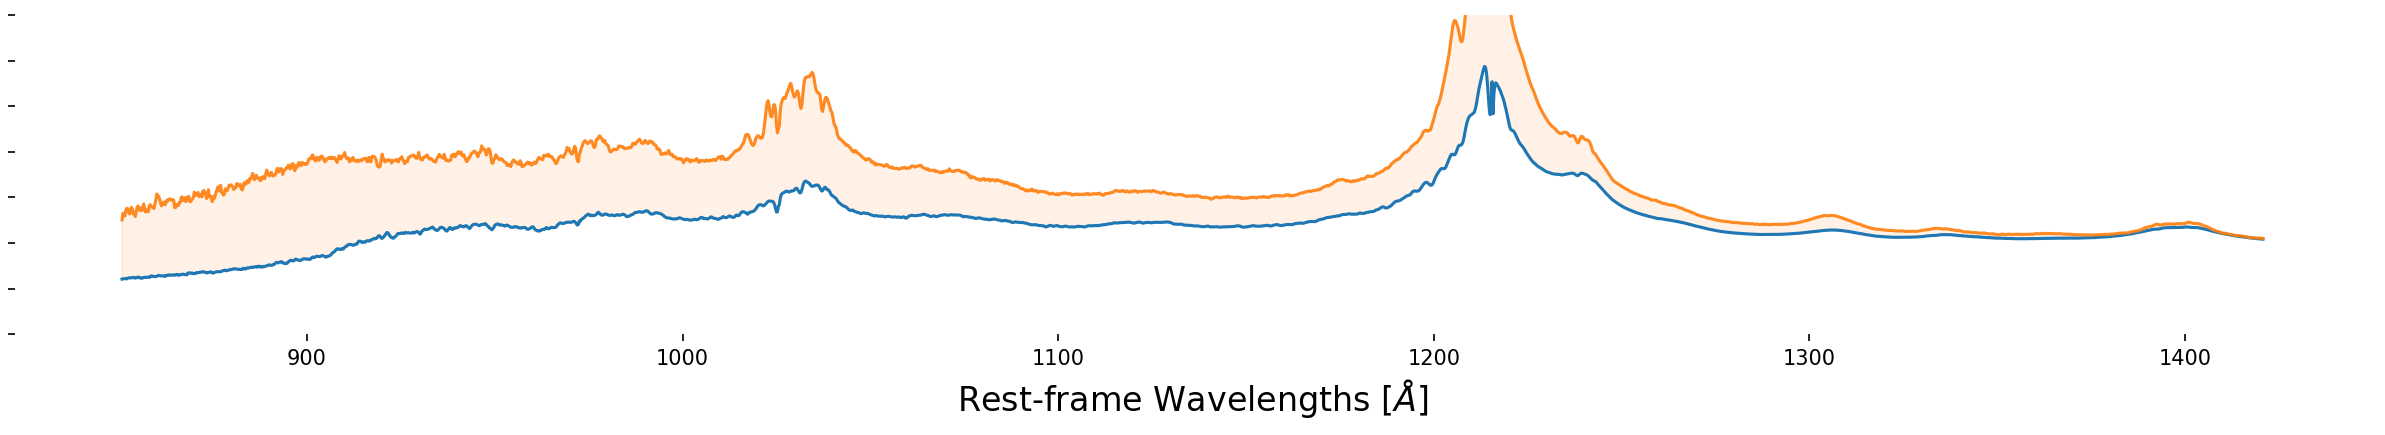

In [25]:
make_gp_sample_plot(sort_index[0])

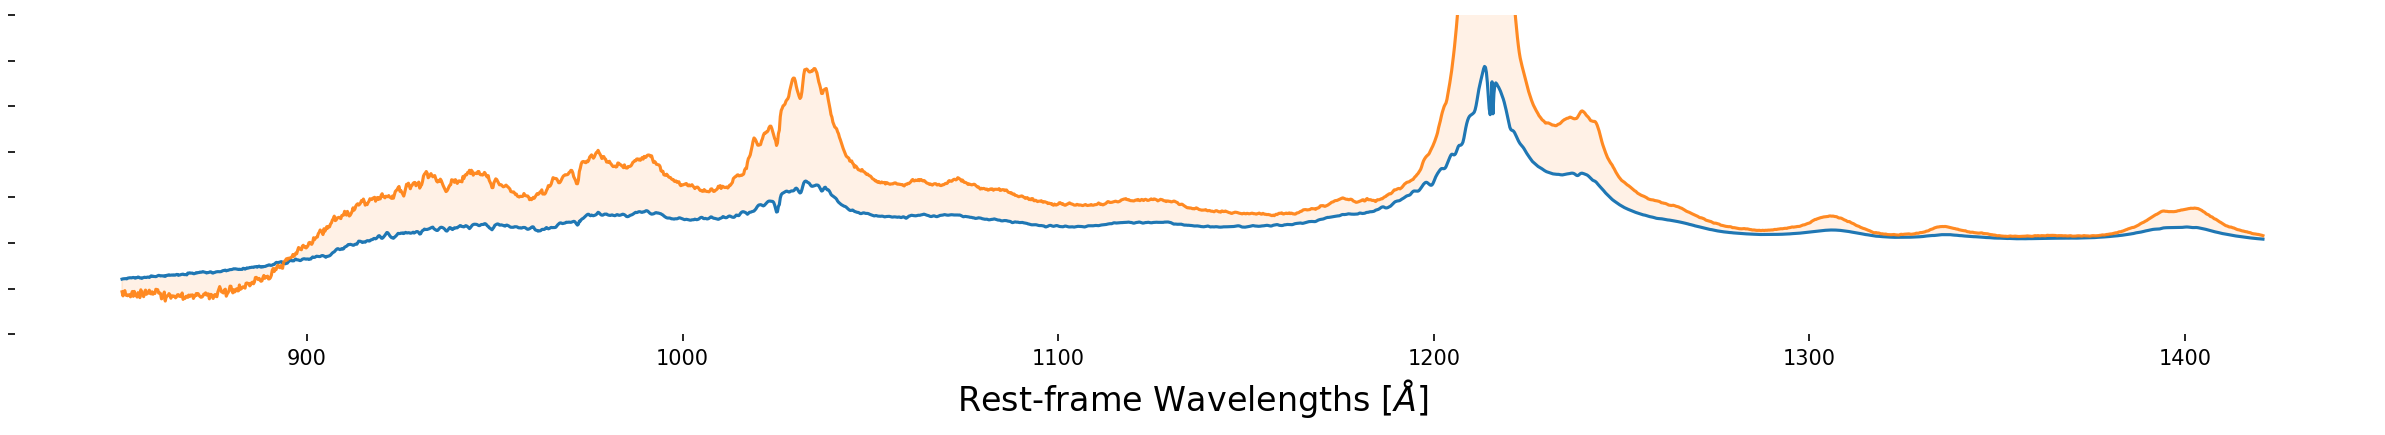

In [29]:
make_gp_sample_plot(sort_index[25])

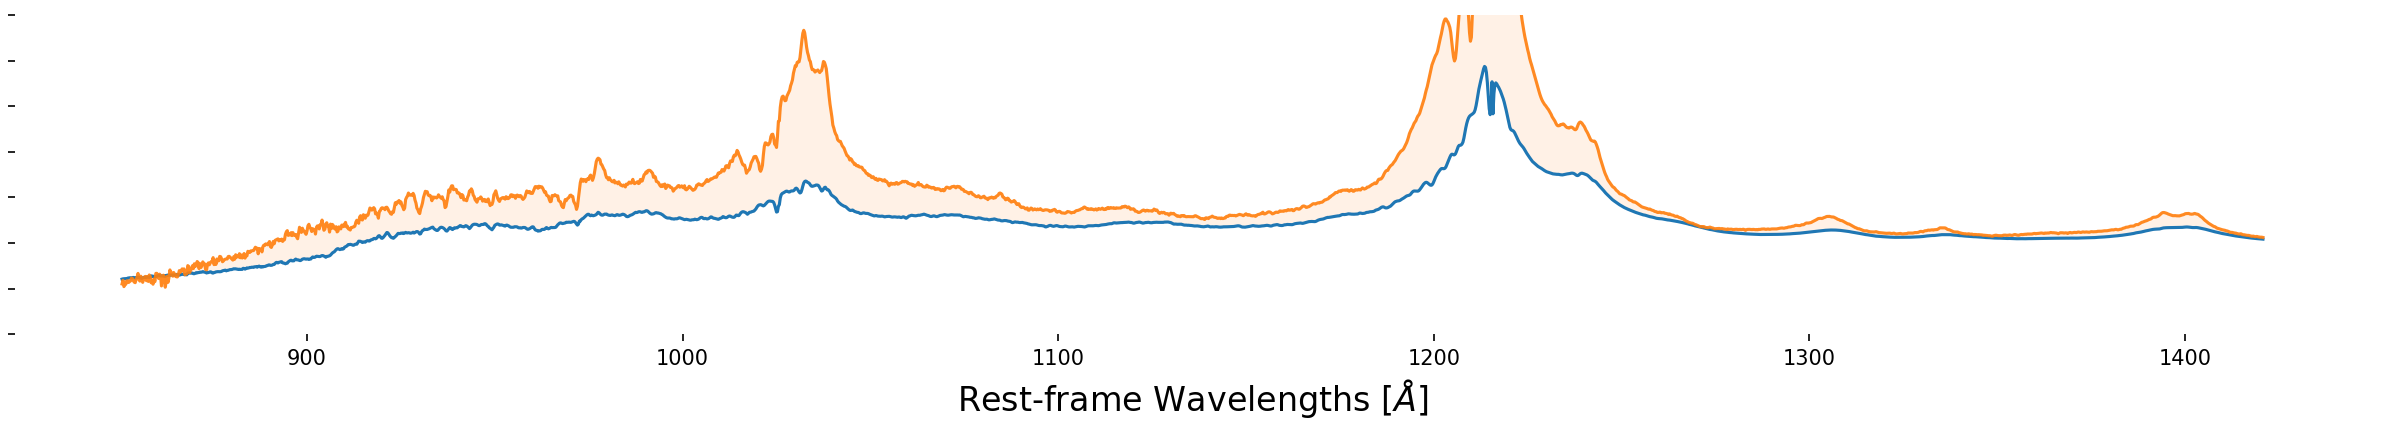

In [28]:
make_gp_sample_plot(sort_index[15])

Negative flux does not physically make sense, maybe need to discuss about this.


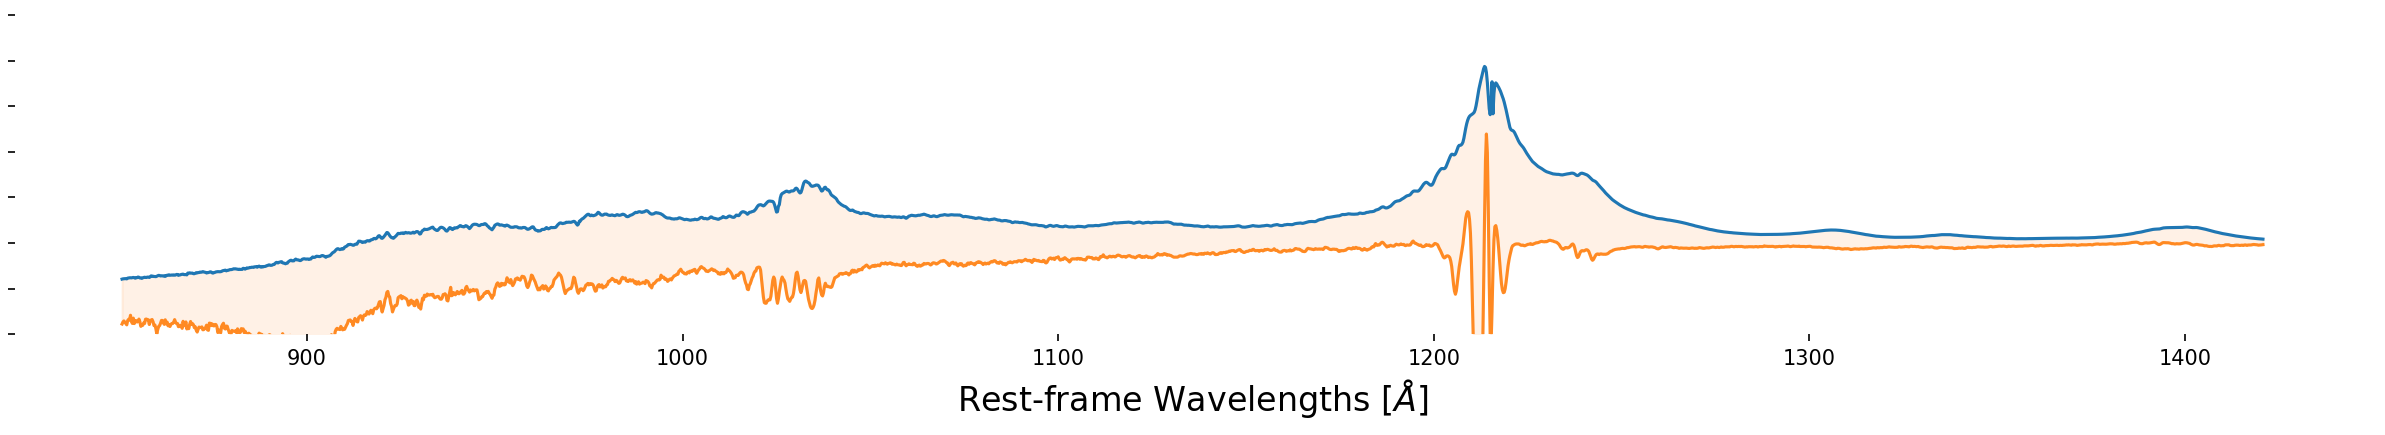

In [26]:
make_gp_sample_plot(sort_index[-1])